# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Muhammad Syaoki Faradisa
- Email: syaokifaradisa09@gmail.com
- Id Dicoding: syaokifaradisa09

## Persiapan

### **Instalasi Library**

In [66]:
pip install xgboost

### **Menyiapkan library yang dibutuhkan**

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
import math
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Student Performance"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Menyiapkan data yang akan diguankan**

In [68]:
df = pd.read_csv(f"{PROJECT_PATH}/data.csv", sep = ";")
df

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## **Data Understanding**

### **Informasi Dataset**

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

Dataset ini berisi 4424 data mahasiswa dengan 37 fitur dan kondisinya sangat baik karena tidak memiliki nilai yang hilang sama sekali. Fitur-fiturnya merupakan campuran antara data numerik (seperti nilai dan data ekonomi) dan data kategorikal (seperti status pernikahan). Kolom Status kemungkinan besar adalah variabel target yang ingin diprediksi, menjadikan dataset ini ideal untuk tugas klasifikasi seperti memprediksi kelulusan atau dropout mahasiswa.

### **Persebaran Label  Status**

In [71]:
df.Status.value_counts()

,count
Status,
Graduate,2209
Dropout,1421
Enrolled,794


Analisis kolom Status menunjukkan dataset ini tidak seimbang. Jumlah mahasiswa Graduate (2.209) jauh lebih banyak daripada Dropout (1.421) dan Enrolled (794). Kondisi ini sangat penting karena akan membuat model prediksi menjadi bias—cenderung akurat menebak 'Graduate' tetapi lemah dalam mengidentifikasi mahasiswa 'Dropout' atau 'Enrolled', yang seringkali merupakan hasil yang paling krusial untuk diprediksi.

### **Distribusi Fitur Kategorikal**

#### **Duplikasi Dataframe Untuk keperluan EDA**

Ini diperlukan agar proses mapping label tidak mengganggtu dataframe utama

In [72]:
df_eda = df.copy()

#### **Status Pernikahan**

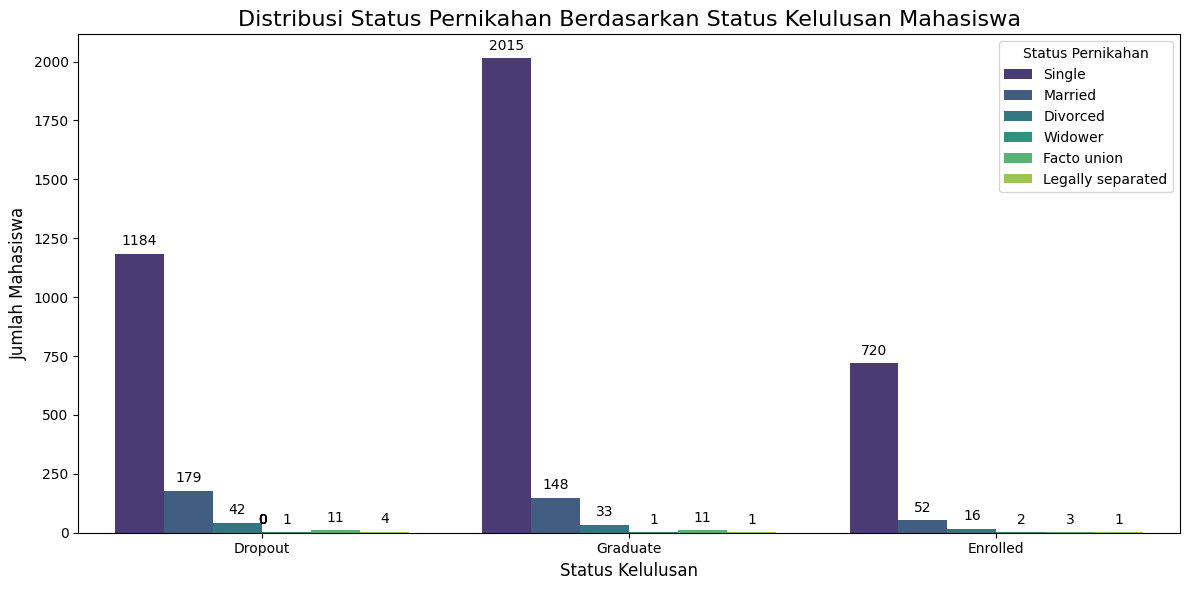

In [73]:
# Mapping
df_eda['Marital_status'] = df_eda['Marital_status'].map({
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
})

# Ukuran Plot
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Marital_status',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Status Pernikahan Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Status Pernikahan')
plt.tight_layout()
plt.show()

Grafik menunjukkan bahwa mayoritas mahasiswa dalam semua kategori kelulusan (dropout, graduate, enrolled) berstatus single, dengan jumlah tertinggi pada kategori lulus yaitu 2.015 orang. Mahasiswa yang menikah cenderung lebih banyak yang dropout (179) dibandingkan yang lulus (148), yang dapat mengindikasikan bahwa pernikahan selama masa studi berpotensi menjadi faktor risiko terhadap kelulusan.

Sementara itu, status pernikahan non-umum seperti divorced, widower, facto union, dan legally separated hanya mewakili sebagian kecil populasi dan tidak memberikan pengaruh signifikan terhadap distribusi kelulusan. Secara keseluruhan, mahasiswa yang belum menikah tampak lebih dominan dan memiliki kecenderungan lebih tinggi untuk menyelesaikan studi dibandingkan yang sudah menikah.

#### **Jalur Masuk Pendaftaran**

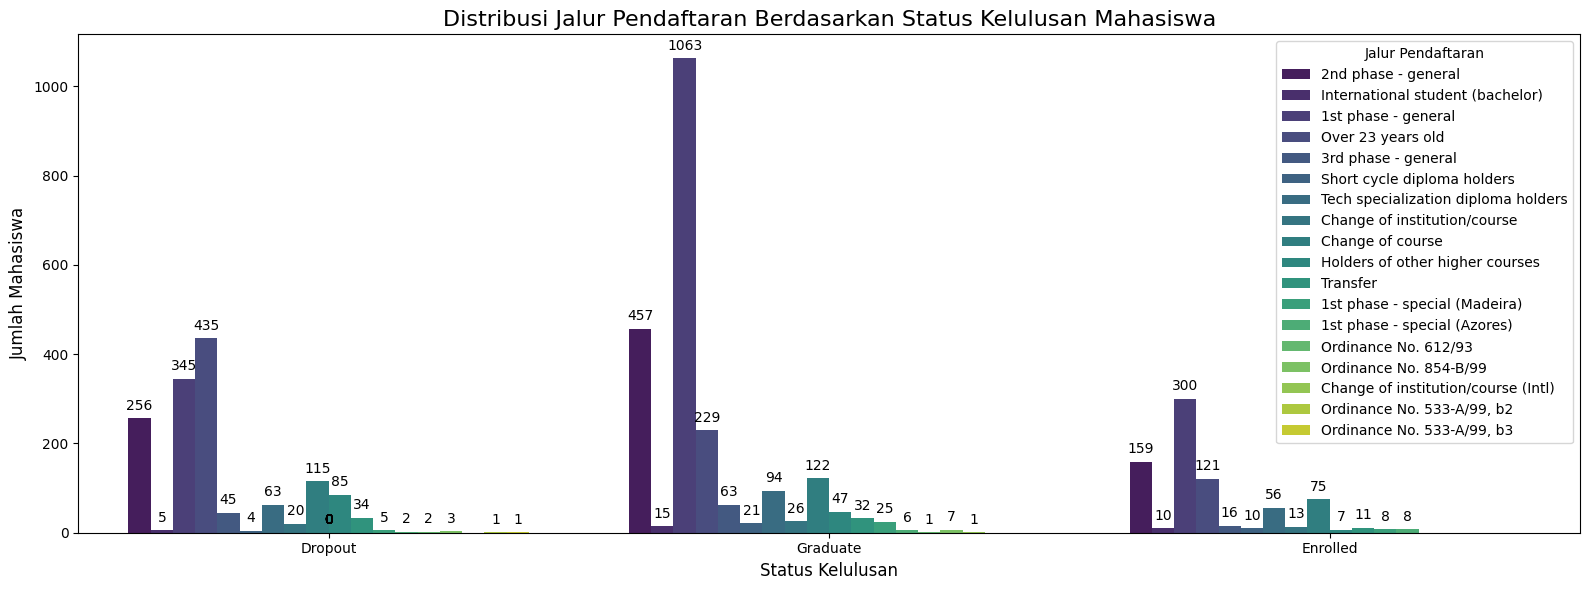

In [74]:
df_eda['Application_mode'] = df_eda['Application_mode'].map({
    1: '1st phase - general',
    2: 'Ordinance No. 612/93',
    5: '1st phase - special (Azores)',
    7: 'Holders of other higher courses',
    10: 'Ordinance No. 854-B/99',
    15: 'International student (bachelor)',
    16: '1st phase - special (Madeira)',
    17: '2nd phase - general',
    18: '3rd phase - general',
    26: 'Ordinance No. 533-A/99, b2',
    27: 'Ordinance No. 533-A/99, b3',
    39: 'Over 23 years old',
    42: 'Transfer',
    43: 'Change of course',
    44: 'Tech specialization diploma holders',
    51: 'Change of institution/course',
    53: 'Short cycle diploma holders',
    57: 'Change of institution/course (Intl)'
})

# Ukuran Plot
plt.figure(figsize=(16, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Application_mode',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Jalur Pendaftaran Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Jalur Pendaftaran')
plt.tight_layout()
plt.show()

Berdasarkan grafik dapat disimpulkan bahwa mayoritas mahasiswa yang lulus berasal dari jalur 1st phase - general (1.063 mahasiswa), menunjukkan bahwa jalur ini merupakan jalur masuk paling umum dan efektif dalam mendukung kelulusan. Di sisi lain, jalur yang sama juga mendominasi angka dropout (435) dan mahasiswa aktif (300), mengindikasikan bahwa meskipun populer, jalur ini juga memiliki tingkat kegagalan yang cukup tinggi.

Jalur 2nd phase - general dan Over 23 years old juga menyumbang angka signifikan dalam kelulusan dan dropout, menunjukkan bahwa berbagai latar belakang usia dan waktu pendaftaran masih memiliki peluang kelulusan yang baik.

Sementara itu, jalur-jalur khusus seperti Change of course, Transfer, dan Change of institution/course memiliki angka lulus yang relatif kecil namun tetap menunjukkan keberhasilan mahasiswa yang berpindah jalur studi.

Keseluruhan data menunjukkan bahwa meskipun jalur masuk awal memiliki peran penting dalam kelulusan, mahasiswa dari berbagai jalur alternatif tetap memiliki peluang untuk menyelesaikan pendidikan mereka.

#### **Kelas**

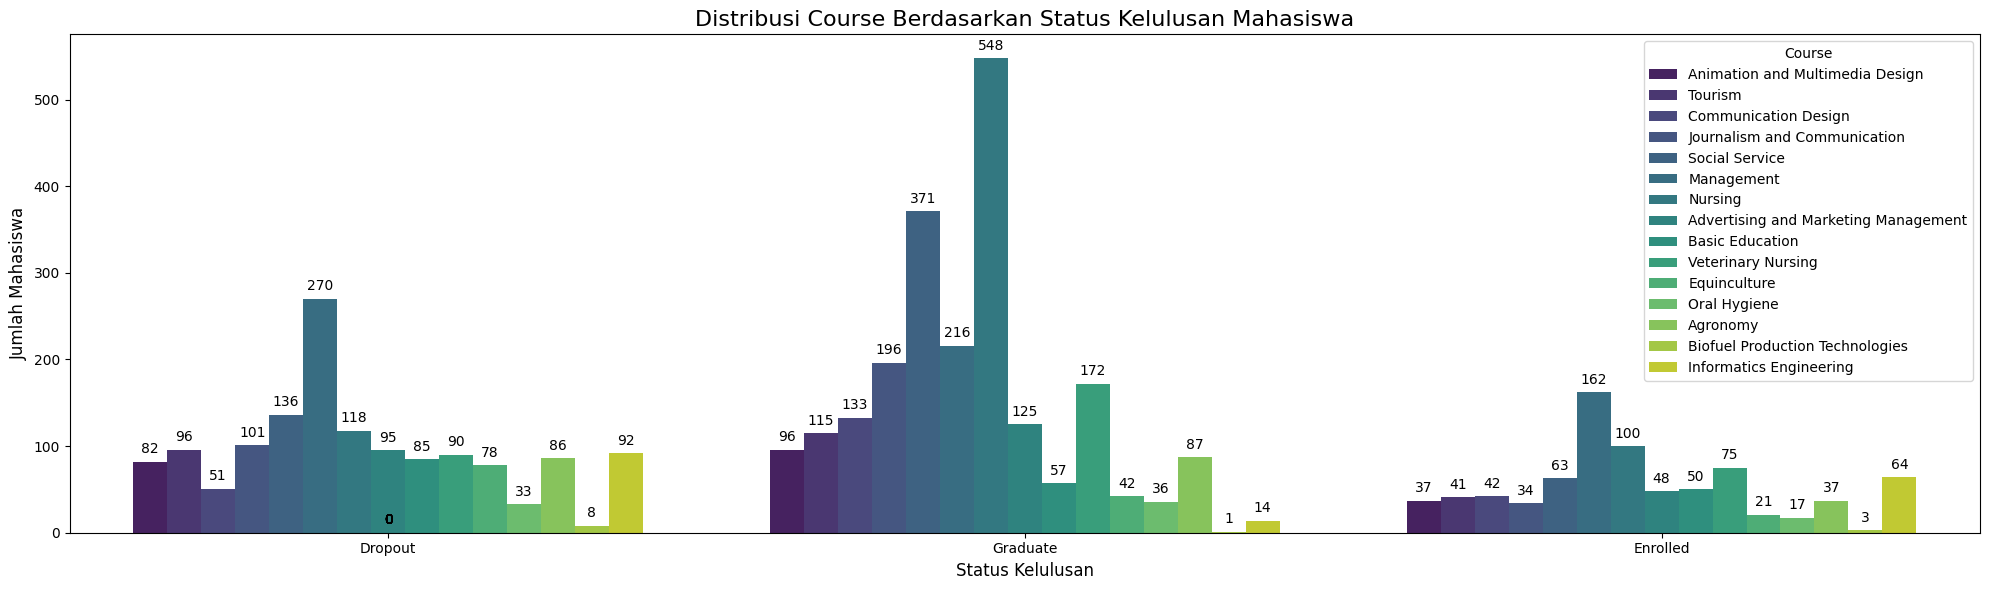

In [75]:
df_eda['Course'] = df_eda['Course'].map({
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management'
})

# Ukuran Plot
plt.figure(figsize=(20, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Course',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Course Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Course')
plt.tight_layout()
plt.show()

Berdasarkan grafik "Distribusi Course Berdasarkan Status Kelulusan Mahasiswa", program studi Nursing menjadi yang paling dominan dalam jumlah kelulusan, dengan total 548 lulusan, jauh melampaui program studi lainnya. Diikuti oleh Social Service (371 lulusan) dan Management (216 lulusan), menunjukkan bahwa ketiga bidang ini memiliki tingkat penyelesaian studi yang tinggi.

Namun, Nursing juga memiliki angka dropout tertinggi (270 mahasiswa), diikuti oleh Management (118) dan Social Service (136), yang mengindikasikan bahwa meskipun banyak yang berhasil lulus, tidak sedikit pula yang tidak menyelesaikan studi.

Sementara itu, program Informatics Engineering menunjukkan keseimbangan yang baik dengan 92 lulusan dan hanya 92 dropout, serta jumlah mahasiswa aktif yang cukup tinggi (64), menunjukkan potensi keberlanjutan. Beberapa program seperti Equinculture dan Biofuel Production Technologies memiliki angka yang sangat kecil baik pada lulusan maupun mahasiswa aktif, menandakan bahwa program ini kurang diminati atau memiliki intake terbatas.

Secara umum, grafik ini mencerminkan variasi keberhasilan akademik berdasarkan bidang studi dan dapat menjadi acuan dalam evaluasi efektivitas program.

#### **waktu atau sesi perkuliahan**

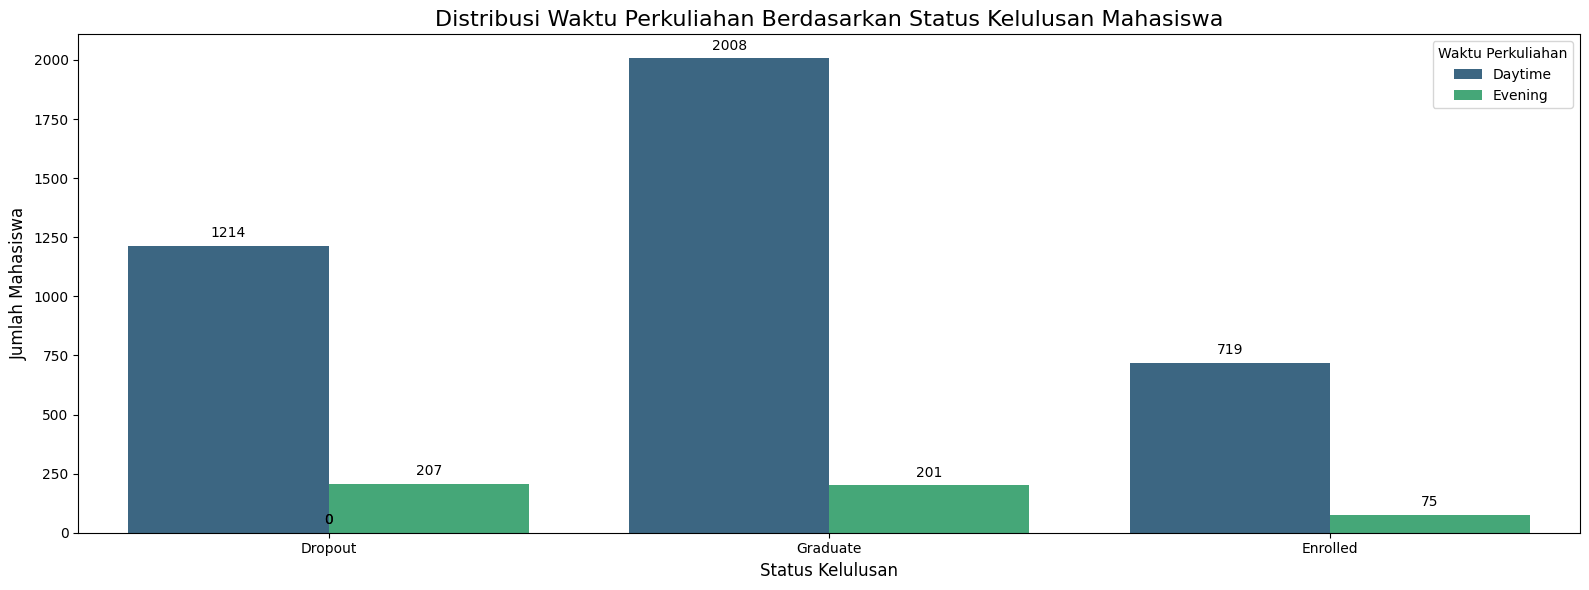

In [76]:
df_eda['Daytime_evening_attendance']= df_eda['Daytime_evening_attendance'].map({
    0: 'Evening',
    1: 'Daytime'
})

# Ukuran Plot
plt.figure(figsize=(16, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Daytime_evening_attendance',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Waktu Perkuliahan Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Waktu Perkuliahan')
plt.tight_layout()
plt.show()

Secara keseluruhan, perkuliahan Daytime lebih diminati dan menunjukkan tingkat kelulusan yang lebih tinggi secara absolut. Namun, Evening memiliki proporsi kelulusan yang hampir setara dengan dropout, yang menunjukkan perlunya perhatian khusus dalam mendukung mahasiswa kelas malam agar tetap bertahan dan menyelesaikan studi.

#### **Kualifikasi Pendidikan Sebelumnya**

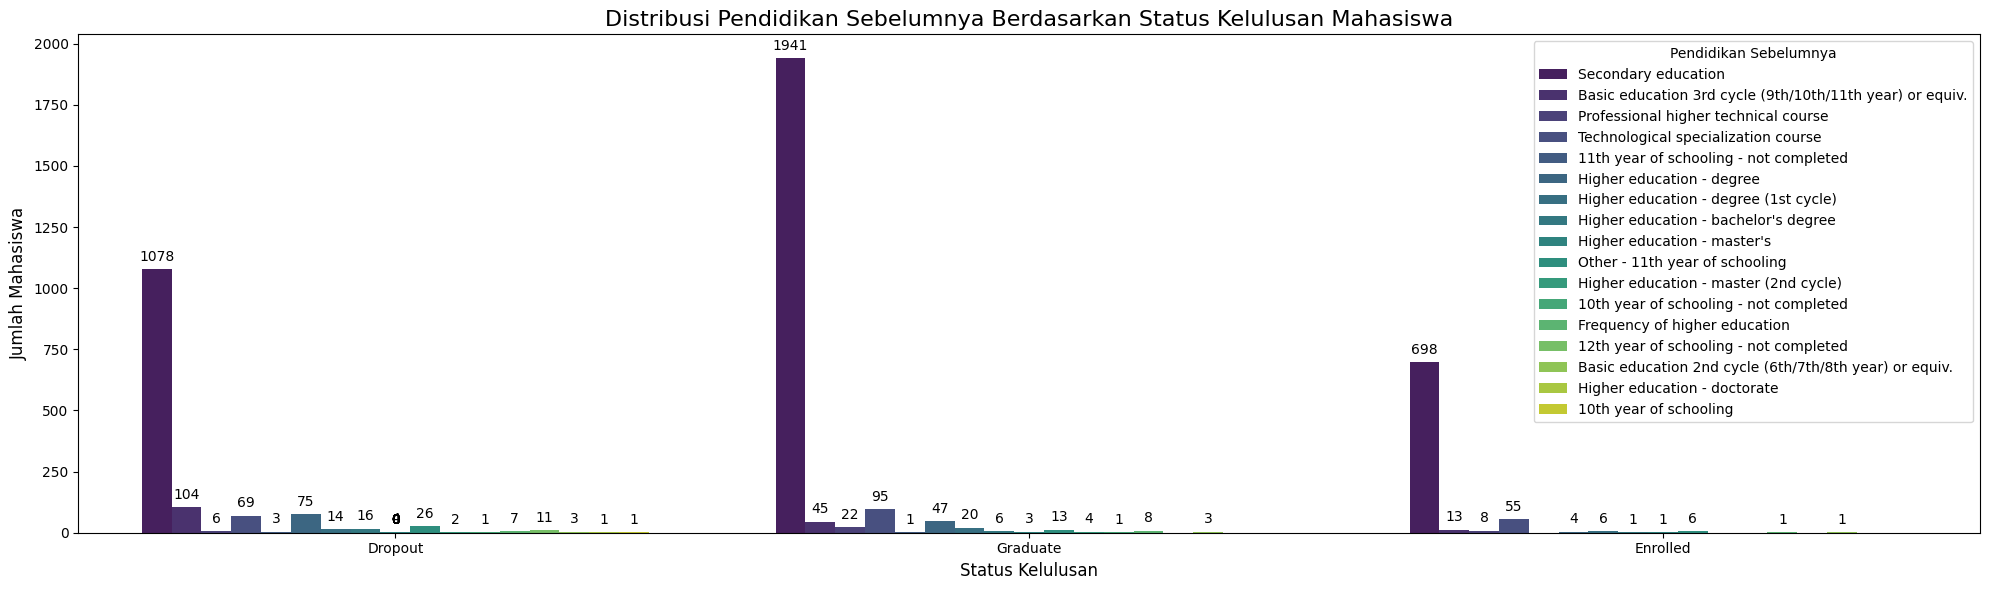

In [77]:
df_eda['Previous_qualification'] = df_eda['Previous_qualification'].map({
    1: 'Secondary education',
    2: 'Higher education - bachelor\'s degree',
    3: 'Higher education - degree',
    4: 'Higher education - master\'s',
    5: 'Higher education - doctorate',
    6: 'Frequency of higher education',
    9: '12th year of schooling - not completed',
    10: '11th year of schooling - not completed',
    12: 'Other - 11th year of schooling',
    14: '10th year of schooling',
    15: '10th year of schooling - not completed',
    19: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    38: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    42: 'Professional higher technical course',
    43: 'Higher education - master (2nd cycle)'
})

# Ukuran Plot
plt.figure(figsize=(20, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Previous_qualification',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Pendidikan Sebelumnya Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Pendidikan Sebelumnya')
plt.tight_layout()
plt.show()

Berdasarkan grafik distribusi pendidikan sebelumnya terhadap status kelulusan mahasiswa, mayoritas mahasiswa berasal dari jenjang secondary education, dengan jumlah terbesar pada kategori lulusan (graduate) sebesar 1.941 mahasiswa, diikuti oleh dropout (1.078) dan masih terdaftar (698).

Selain itu, jalur pendidikan seperti professional higher technical course dan technological specialization course juga memiliki kontribusi signifikan terhadap kelulusan, meskipun jumlahnya jauh lebih kecil.

Sebaliknya, jalur pendidikan lanjutan seperti higher education - master's atau doctorate hanya menyumbang sebagian kecil dari keseluruhan populasi, yang menunjukkan bahwa sebagian besar mahasiswa memasuki pendidikan tinggi langsung dari pendidikan menengah.

Pola kelulusan dari berbagai latar pendidikan relatif konsisten, namun dominasi lulusan dari secondary education menunjukkan bahwa jenjang tersebut merupakan titik masuk utama ke pendidikan tinggi di institusi ini.

#### **Kualifikasi Pendidikan Ibu**

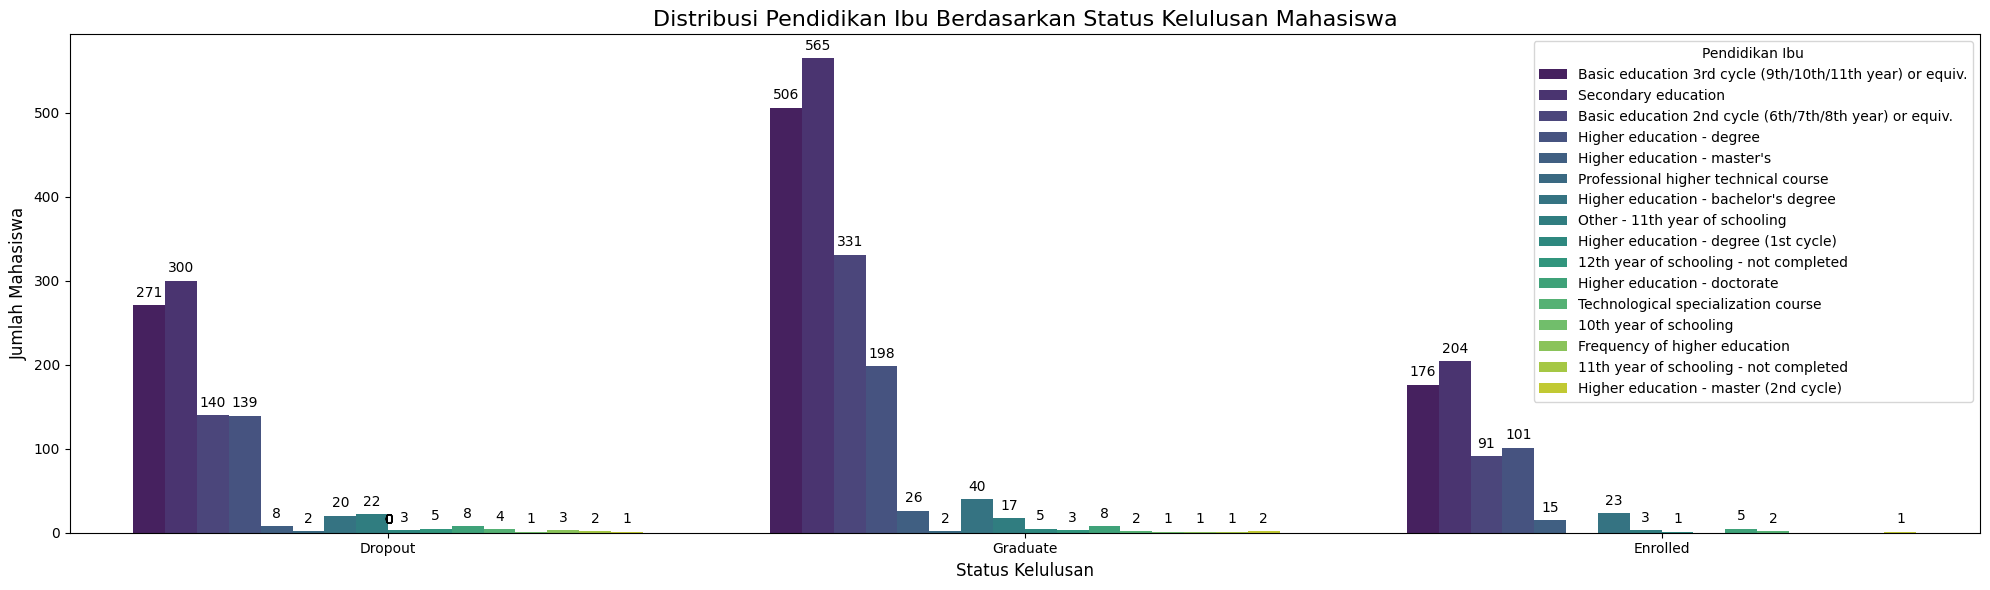

In [78]:
df_eda['Mothers_qualification'] = df_eda['Mothers_qualification'].map({
    1: 'Secondary education',
    2: 'Higher education - bachelor\'s degree',
    3: 'Higher education - degree',
    4: 'Higher education - master\'s',
    5: 'Higher education - doctorate',
    6: 'Frequency of higher education',
    9: '12th year of schooling - not completed',
    10: '11th year of schooling - not completed',
    12: 'Other - 11th year of schooling',
    14: '10th year of schooling',
    15: '10th year of schooling - not completed',
    19: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    38: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    42: 'Professional higher technical course',
    43: 'Higher education - master (2nd cycle)'
})

# Ukuran Plot
plt.figure(figsize=(20, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Mothers_qualification',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Pendidikan Ibu Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Pendidikan Ibu')
plt.tight_layout()
plt.show()

Analisis grafik menunjukkan adanya korelasi kuat antara tingkat pendidikan ibu dan status kelulusan mahasiswa. Meskipun jumlah absolut mahasiswa terbesar di semua kategori (lulus, dropout, dan terdaftar) berasal dari ibu dengan pendidikan dasar dan menengah, insight yang paling krusial adalah pergeseran proporsi keberhasilan. Semakin tinggi jenjang pendidikan seorang ibu, terutama hingga tingkat sarjana, rasio mahasiswa yang berhasil lulus secara signifikan lebih besar dibandingkan dengan yang putus studi. Hal ini secara jelas mengindikasikan bahwa latar belakang pendidikan tinggi seorang ibu merupakan faktor pendukung yang kuat yang berkontribusi positif terhadap peningkatan persistensi dan angka kelulusan mahasiswa.

#### **Kualifikasi Pendidikan Ayah**

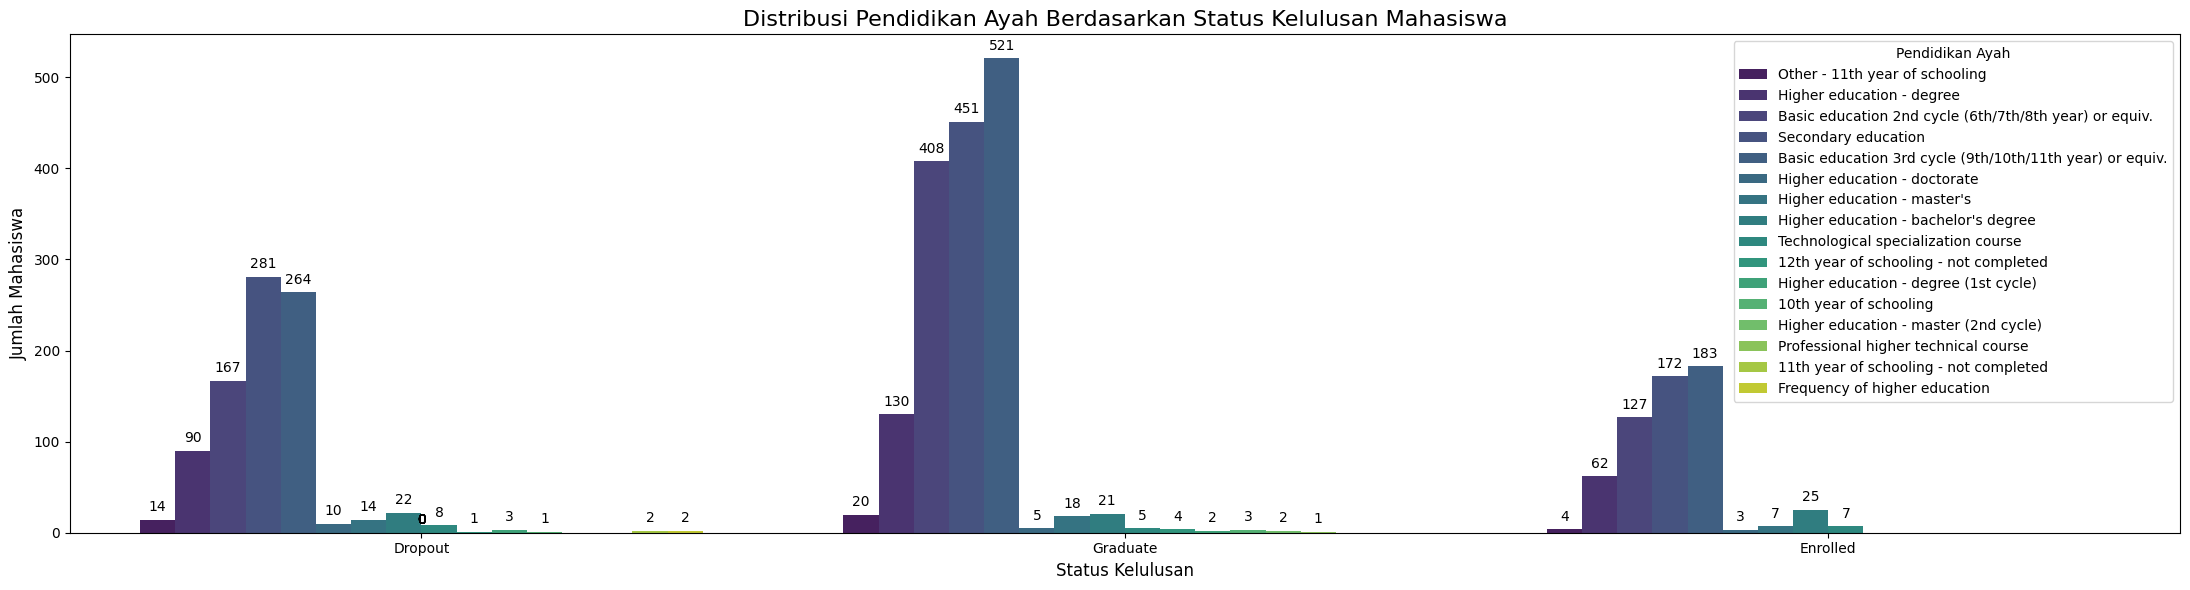

In [79]:
df_eda['Fathers_qualification'] = df_eda['Fathers_qualification'].map({
    1: 'Secondary education',
    2: 'Higher education - bachelor\'s degree',
    3: 'Higher education - degree',
    4: 'Higher education - master\'s',
    5: 'Higher education - doctorate',
    6: 'Frequency of higher education',
    9: '12th year of schooling - not completed',
    10: '11th year of schooling - not completed',
    12: 'Other - 11th year of schooling',
    14: '10th year of schooling',
    15: '10th year of schooling - not completed',
    19: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    38: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    42: 'Professional higher technical course',
    43: 'Higher education - master (2nd cycle)'
})

# Ukuran Plot
plt.figure(figsize=(22, 6))

ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Fathers_qualification',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Distribusi Pendidikan Ayah Berdasarkan Status Kelulusan Mahasiswa', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

# Menampilkan plot
plt.legend(title='Pendidikan Ayah')
plt.tight_layout()
plt.show()

Serupa dengan analisis sebelumnya mengenai pendidikan ibu, data ini menunjukkan korelasi yang signifikan antara tingkat pendidikan ayah dan status kelulusan mahasiswa. Meskipun ayah dengan latar belakang pendidikan menengah (Secondary education) dan pendidikan dasar (Basic education) merupakan kelompok terbesar secara jumlah absolut di semua kategori, poin kuncinya terletak pada proporsi keberhasilan. Terlihat jelas bahwa seiring dengan meningkatnya jenjang pendidikan ayah, terutama ke tingkat sarjana dan magister, rasio mahasiswa yang berhasil lulus menjadi jauh lebih tinggi dibandingkan dengan yang dropout. Hal ini menegaskan bahwa tingkat pendidikan ayah yang lebih tinggi juga merupakan faktor pendukung yang kuat, yang berkontribusi secara positif dalam meningkatkan peluang keberhasilan akademik dan menekan angka putus studi mahasiswa.

#### **Pekerjaan Ayah**

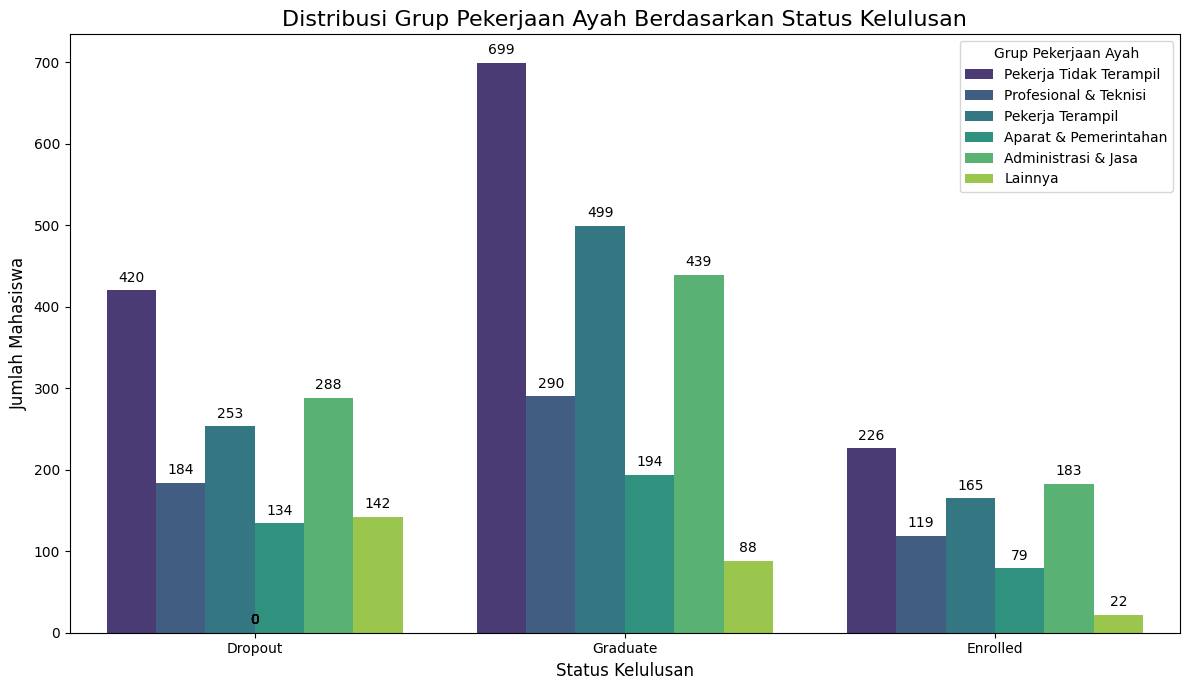

In [80]:
df_eda['Fathers_occupation'] = df_eda['Fathers_occupation'].map({
    0: 'Student',
    1: 'Legislative/Executive Power, Directors',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants',
    103: 'Other Armed Forces personnel',
    112: 'Directors of administrative and commercial services',
    114: 'Hotel, catering, trade and other services directors',
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    122: 'Health professionals',
    123: 'Teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel',
    161: 'Market-oriented farmers and skilled agricultural and animal production workers',
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar',
    174: 'Skilled workers in electricity and electronics',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators',
    182: 'Assembly workers',
    183: 'Vehicle drivers and mobile equipment operators',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers'
})

# 1. Definisikan pemetaan grup
occupation_groups = {
    # Grup Profesional & Teknisi
    'Specialists in Intellectual and Scientific Activities': 'Profesional & Teknisi',
    'Intermediate Level Technicians and Professions': 'Profesional & Teknisi',
    'Specialists in the physical sciences, mathematics, engineering and related techniques': 'Profesional & Teknisi',
    'Health professionals': 'Profesional & Teknisi',
    'Teachers': 'Profesional & Teknisi',
    'Intermediate level science and engineering technicians and professions': 'Profesional & Teknisi',
    'Technicians and professionals, of intermediate level of health': 'Profesional & Teknisi',
    'Information and communication technology technicians': 'Profesional & Teknisi',
    'Specialists in finance, accounting, administrative organization, public and commercial relations': 'Profesional & Teknisi',

    # Grup Administrasi & Jasa
    'Administrative staff': 'Administrasi & Jasa',
    'Personal Services, Security and Safety Workers and Sellers': 'Administrasi & Jasa',
    'Office workers, secretaries in general and data processing operators': 'Administrasi & Jasa',
    'Data, accounting, statistical, financial services and registry-related operators': 'Administrasi & Jasa',
    'Sellers': 'Administrasi & Jasa',
    'Personal service workers': 'Administrasi & Jasa',
    'Hotel, catering, trade and other services directors': 'Administrasi & Jasa',

    # Grup Pekerja Terampil
    'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry': 'Pekerja Terampil',
    'Skilled Workers in Industry, Construction and Craftsmen': 'Pekerja Terampil',
    'Market-oriented farmers and skilled agricultural and animal production workers': 'Pekerja Terampil',
    'Skilled construction workers and the like, except electricians': 'Pekerja Terampil',

    # Grup Aparat & Pemerintahan
    'Legislative/Executive Power, Directors': 'Aparat & Pemerintahan',
    'Armed Forces Professions': 'Aparat & Pemerintahan',
    'Armed Forces Officers': 'Aparat & Pemerintahan',
    'Armed Forces Sergeants': 'Aparat & Pemerintahan',
    'Other Armed Forces personnel': 'Aparat & Pemerintahan',

    # Grup Pekerja Tidak Terampil
    'Unskilled Workers': 'Pekerja Tidak Terampil',
    'Installation and Machine Operators and Assembly Workers': 'Pekerja Tidak Terampil',
    'Unskilled workers in extractive industry, construction, manufacturing and transport': 'Pekerja Tidak Terampil',
    'Meal preparation assistants': 'Pekerja Tidak Terampil',

    # Grup Lainnya
    'Student': 'Lainnya',
    'Other Situation': 'Lainnya',
    '(blank)': 'Lainnya'
}

df_eda['Fathers_occupation_group'] = df_eda['Fathers_occupation'].apply(lambda x: occupation_groups.get(x, 'Lainnya'))

# 3. Buat visualisasi BARU dengan kolom grup
plt.figure(figsize=(12, 7)) # Ukuran bisa disesuaikan
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Fathers_occupation_group', # Gunakan kolom grup baru
    palette='viridis'
)

plt.title('Distribusi Grup Pekerjaan Ayah Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Grup Pekerjaan Ayah')
plt.tight_layout()
plt.show()

Grafik ini menyoroti profil risiko kelulusan yang sangat bervariasi di antara mahasiswa, dengan insight utama pada dualitas kelompok "Pekerja Tidak Terampil" yang menjadi penyumbang terbesar baik untuk jumlah lulusan (699) maupun angka dropout (420), menandakan partisipasi pendidikan yang luas namun diiringi kerentanan yang tinggi. Kondisi ini sangat kontras dengan kelompok "Lainnya" yang menjadi satu-satunya kategori dengan jumlah dropout (142) yang melebihi jumlah lulusan (88), menjadikannya kelompok dengan rasio keberhasilan paling rendah. Sementara itu, kelompok seperti "Pekerja Terampil" dan "Administrasi & Jasa" menunjukkan pola keberhasilan yang lebih stabil, di mana jumlah lulusan mereka secara konsisten jauh melampaui angka putus kuliah, mengindikasikan jalur akademis yang lebih aman.

#### **Pekerjaan Ibu**

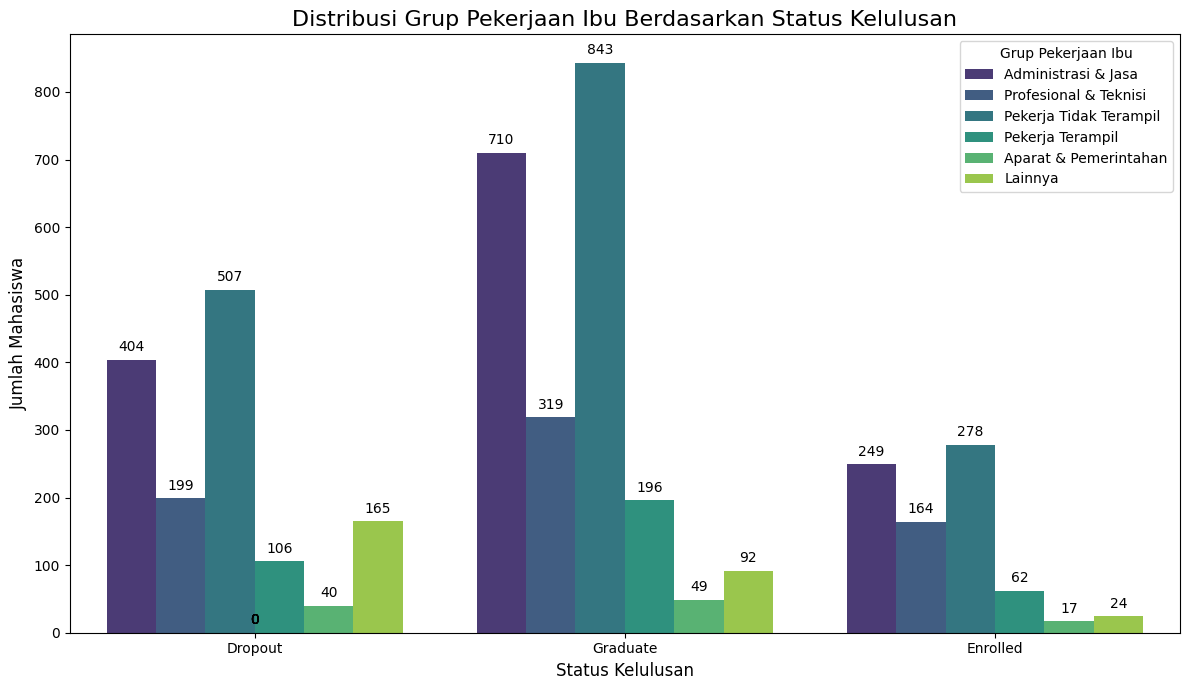

In [81]:
df_eda['Mothers_occupation'] = df['Mothers_occupation'].map({
    0: 'Student',
    1: 'Legislative/Executive Power, Directors',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants',
    103: 'Other Armed Forces personnel',
    112: 'Directors of administrative and commercial services',
    114: 'Hotel, catering, trade and other services directors',
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    122: 'Health professionals',
    123: 'Teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel',
    161: 'Market-oriented farmers and skilled agricultural and animal production workers',
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar',
    174: 'Skilled workers in electricity and electronics',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators',
    182: 'Assembly workers',
    183: 'Vehicle drivers and mobile equipment operators',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers'
})

df_eda['Mothers_occupation_group'] = df_eda['Mothers_occupation'].apply(lambda x: occupation_groups.get(x, 'Lainnya'))

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Mothers_occupation_group',
    palette='viridis'
)

plt.title('Distribusi Grup Pekerjaan Ibu Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Grup Pekerjaan Ibu')
plt.tight_layout()
plt.show()

Dengan membandingkan kedua grafik, terungkap bahwa peran profesional Ayah dan Ibu memiliki korelasi yang berbeda terhadap kelulusan anak. Insight utamanya adalah pengaruh Ibu di sektor "Administrasi & Jasa" yang secara unik sangat kuat dalam mendorong jumlah lulusan, jauh melampaui kontribusi Ayah di sektor yang sama. Sebaliknya, peran Ayah sebagai "Pekerja Terampil" berkorelasi dengan jumlah lulusan yang jauh lebih besar dibandingkan jika Ibu yang memiliki pekerjaan serupa. Sementara itu, kedua grafik secara konsisten menunjukkan bahwa latar belakang "Pekerja Tidak Terampil" dan "Lainnya" merupakan tantangan universal yang sama beratnya, menegaskan bahwa sementara beberapa faktor sosio-ekonomi menciptakan risiko yang konstan, peran spesifik Ayah dan Ibu di dunia kerja memberikan pengaruh yang khas pada keberhasilan akademis anak mereka.

#### **Nasionalisme**

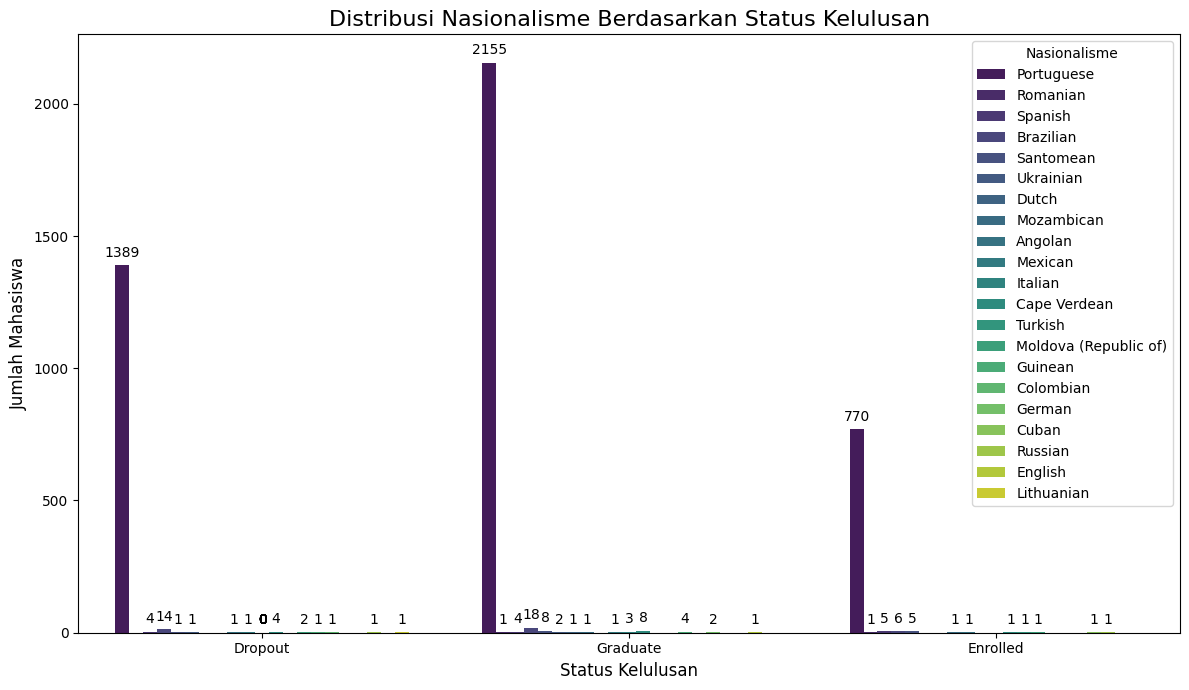

In [82]:
df_eda['Nacionality'] = df['Nacionality'].map({
    1: 'Portuguese',
    2: 'German',
    6: 'Spanish',
    11: 'Italian',
    13: 'Dutch',
    14: 'English',
    17: 'Lithuanian',
    21: 'Angolan',
    22: 'Cape Verdean',
    24: 'Guinean',
    25: 'Mozambican',
    26: 'Santomean',
    32: 'Turkish',
    41: 'Brazilian',
    62: 'Romanian',
    100: 'Moldova (Republic of)',
    101: 'Mexican',
    103: 'Ukrainian',
    105: 'Russian',
    108: 'Cuban',
    109: 'Colombian'
})


plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Nacionality',
    palette='viridis'
)

plt.title('Distribusi Nasionalisme Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Nasionalisme')
plt.tight_layout()
plt.show()

Secara ringkas, insight utama dari grafik ini bukanlah tentang perbandingan antar negara, melainkan sebuah gambaran dari sebuah institusi pendidikan yang populasinya sangat homogen (mayoritas Portugis) dengan sedikit sekali mahasiswa internasional. Poin cerita yang paling penting adalah profil dari populasi mayoritas itu sendiri, yang menunjukkan adanya keberhasilan kelulusan yang diiringi dengan tingkat dropout yang juga sangat tinggi. Karena data ini sangat homogen dan mayoritas pada 1 kategori maka pada proses training nantinya akan dilakukan drop.

#### **Jenis Kelamin**

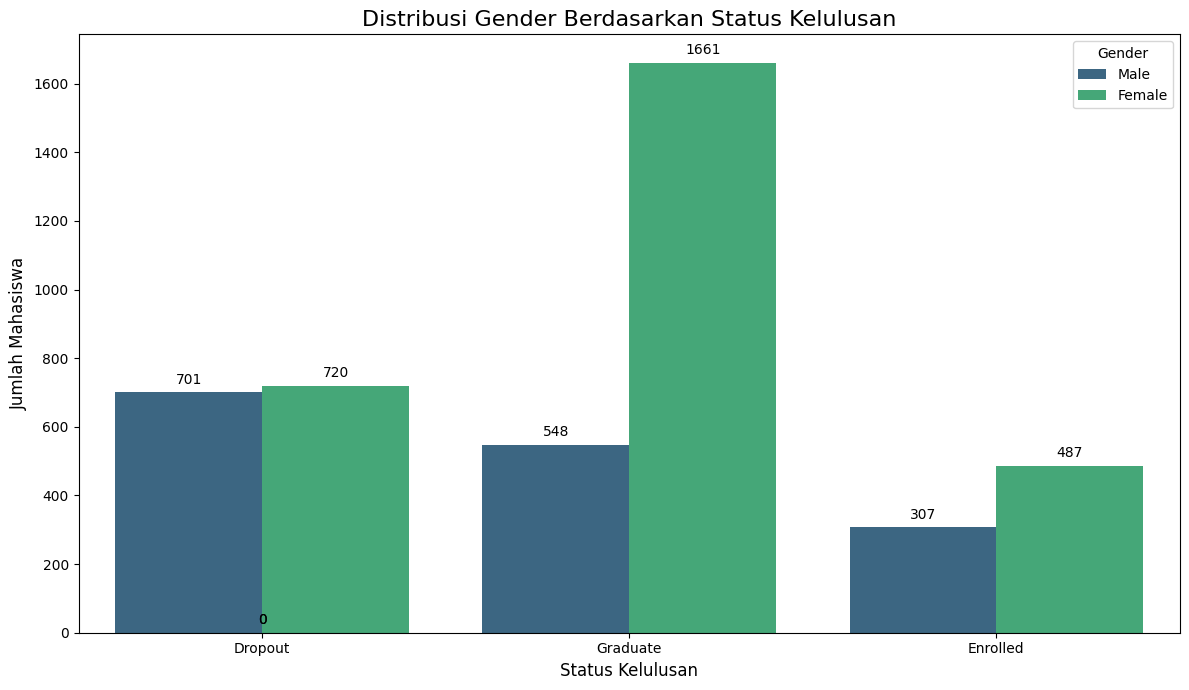

In [83]:
df_eda['Gender'] = df['Gender'].map({
    1: 'Male',
    0: 'Female'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Gender',
    palette='viridis'
)

plt.title('Distribusi Gender Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Gender')
plt.tight_layout()
plt.show()

Secara ringkas, grafik ini menunjukkan adanya kesenjangan gender yang signifikan dalam pencapaian akademis. Mahasiswi tidak hanya mendominasi populasi secara jumlah, tetapi juga secara dramatis lebih unggul dalam tingkat kelulusan. Sebaliknya, mahasiswa pria menghadapi tantangan retensi yang serius, di mana angka putus kuliah mereka melampaui angka kelulusan mereka sendiri.

#### **Displaced**

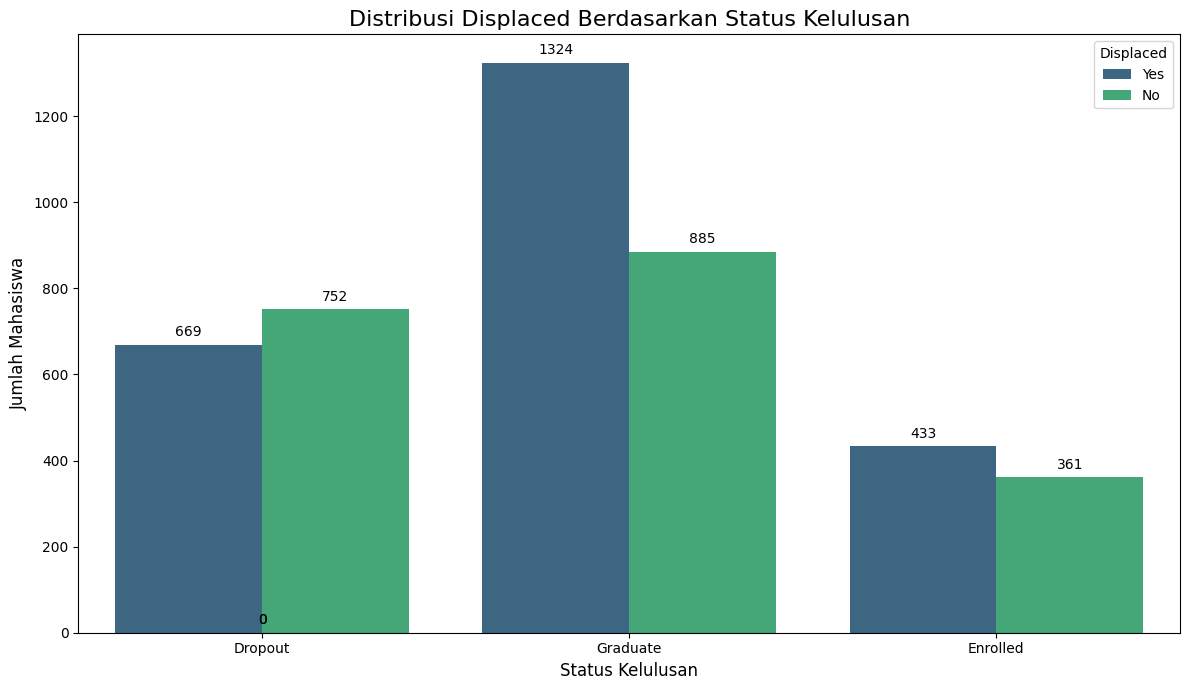

In [84]:
df_eda['Displaced'] = df['Displaced'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Displaced',
    palette='viridis'
)

plt.title('Distribusi Displaced Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Displaced')
plt.tight_layout()
plt.show()

Secara ringkas, status "Displaced" dalam dataset ini bukanlah menjadi faktor risiko, melainkan justru menjadi penanda untuk kohort mahasiswa yang lebih tangguh dan lebih sukses secara akademis. Sebaliknya, perhatian mungkin perlu diberikan kepada mahasiswa lokal (tidak "displaced") yang secara relatif menunjukkan risiko putus kuliah yang lebih tinggi.

#### **Debtor**

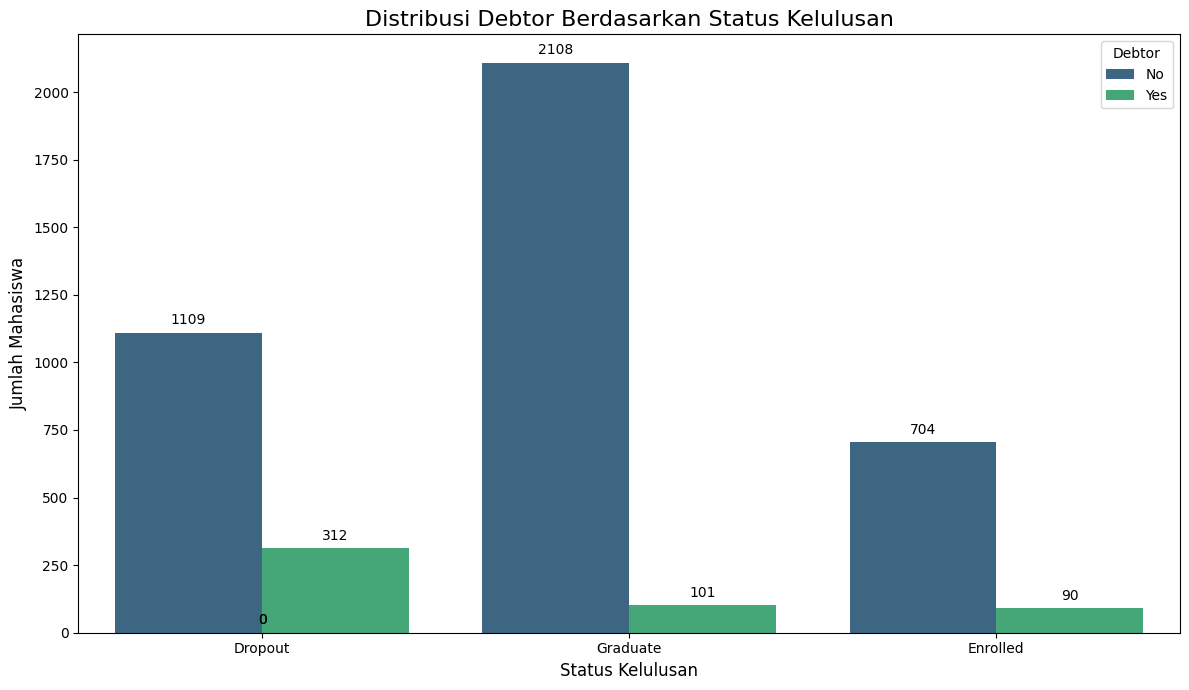

In [85]:
df_eda['Debtor'] = df['Debtor'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Debtor',
    palette='viridis'
)

plt.title('Distribusi Debtor Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Debtor')
plt.tight_layout()
plt.show()

Data ini secara tegas menunjukkan bahwa memiliki utang adalah prediktor kuat untuk putus kuliah, dengan wawasan paling krusial terlihat pada perbandingan rasio kelulusan. Untuk setiap mahasiswa dengan utang yang berhasil lulus, tiga orang lainnya justru putus kuliah, sebuah kondisi yang berbanding terbalik dengan mahasiswa tanpa utang di mana hampir dua orang berhasil lulus untuk setiap satu yang dropout. Beban ini semakin jelas karena meskipun mahasiswa berutang hanya merupakan minoritas kecil dari populasi total, mereka secara tidak proporsional menyumbang persentase yang jauh lebih besar dalam kelompok dropout. Akibatnya, keberhasilan menyelesaikan studi menjadi sangat identik dengan kondisi bebas utang, menegaskan bahwa tekanan finansial adalah salah satu penghalang terbesar untuk mencapai kelulusan.

#### **Educational_special_needs**

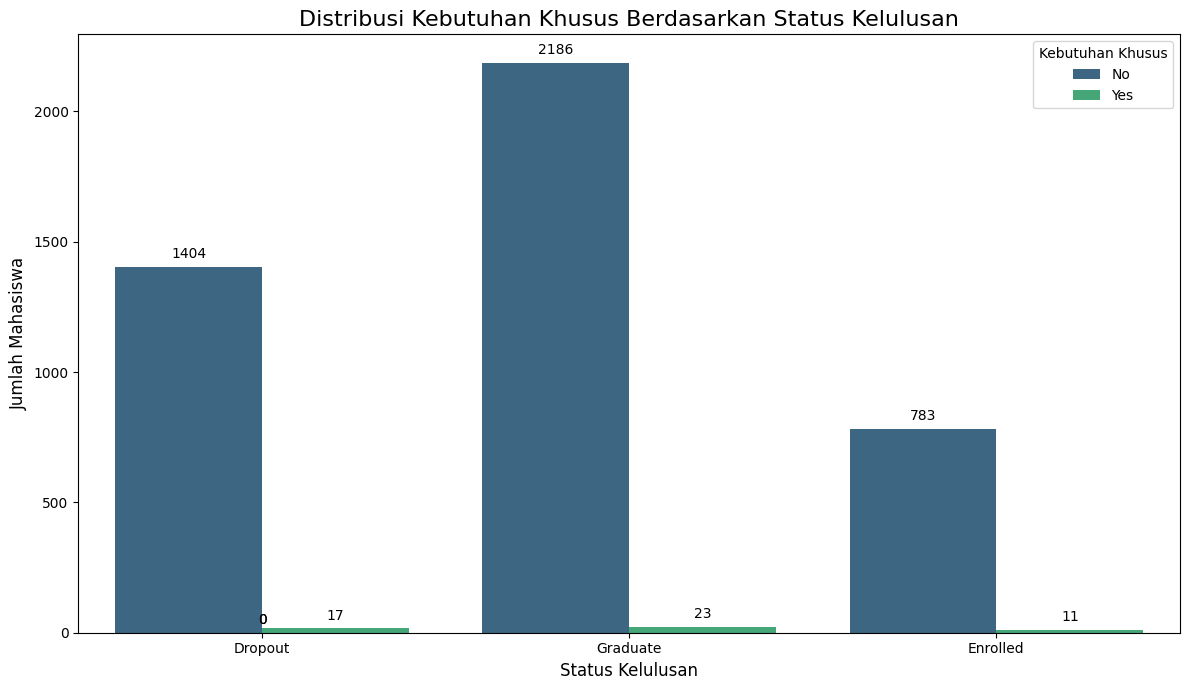

In [86]:
df_eda['Educational_special_needs'] = df['Educational_special_needs'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Educational_special_needs',
    palette='viridis'
)

plt.title('Distribusi Kebutuhan Khusus Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Kebutuhan Khusus')
plt.tight_layout()
plt.show()

Grafik ini adalah tentang sebuah kelompok minoritas yang sangat kecil dalam populasi kampus yang menghadapi risiko akademis yang lebih tinggi. Kesenjangan dalam tingkat dropout, meskipun terlihat kecil, menyoroti adanya potensi kekurangan dalam penyediaan fasilitas dan dukungan yang inklusif.

Dari sudut pandang machine learning, fitur "Kebutuhan Khusus" ini memiliki masalah yang sama dengan fitur "Nasionalisme" sebelumnya (variansi yang sangat rendah). Untuk membangun model prediksi umum, fitur ini kemungkinan besar akan dihapus (di-drop) karena tidak memberikan banyak informasi dan berisiko menyebabkan overfitting.

#### **Tuition_fees_up_to_date**

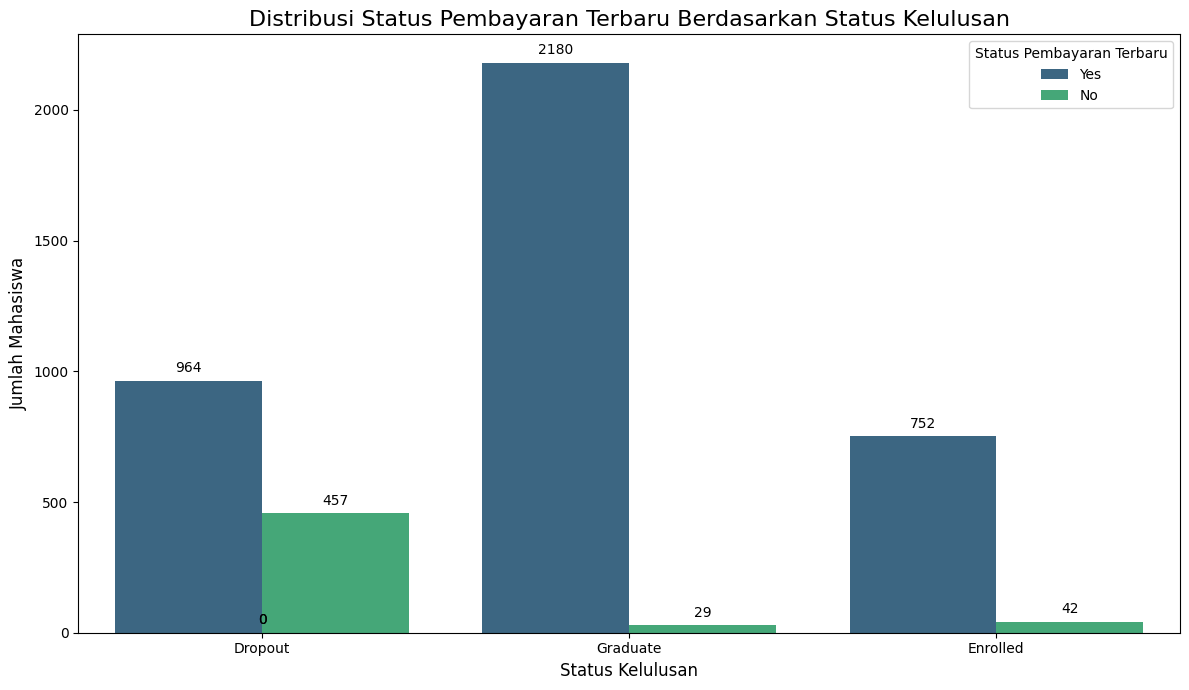

In [87]:
df_eda['Tuition_fees_up_to_date'] = df['Tuition_fees_up_to_date'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Tuition_fees_up_to_date',
    palette='viridis'
)

plt.title('Distribusi Status Pembayaran Terbaru Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Status Pembayaran Terbaru')
plt.tight_layout()
plt.show()

Secara ringkas, grafik ini menunjukkan bahwa kesehatan finansial adalah determinan utama keberhasilan studi, bukan sekadar faktor pendukung. Kesulitan membayar biaya kuliah adalah prediktor paling kuat untuk putus kuliah. Oleh karena itu, strategi retensi mahasiswa yang paling efektif bagi institusi ini harus berpusat pada program dukungan finansial yang proaktif dan mudah diakses.

#### **Scholarship_holder**

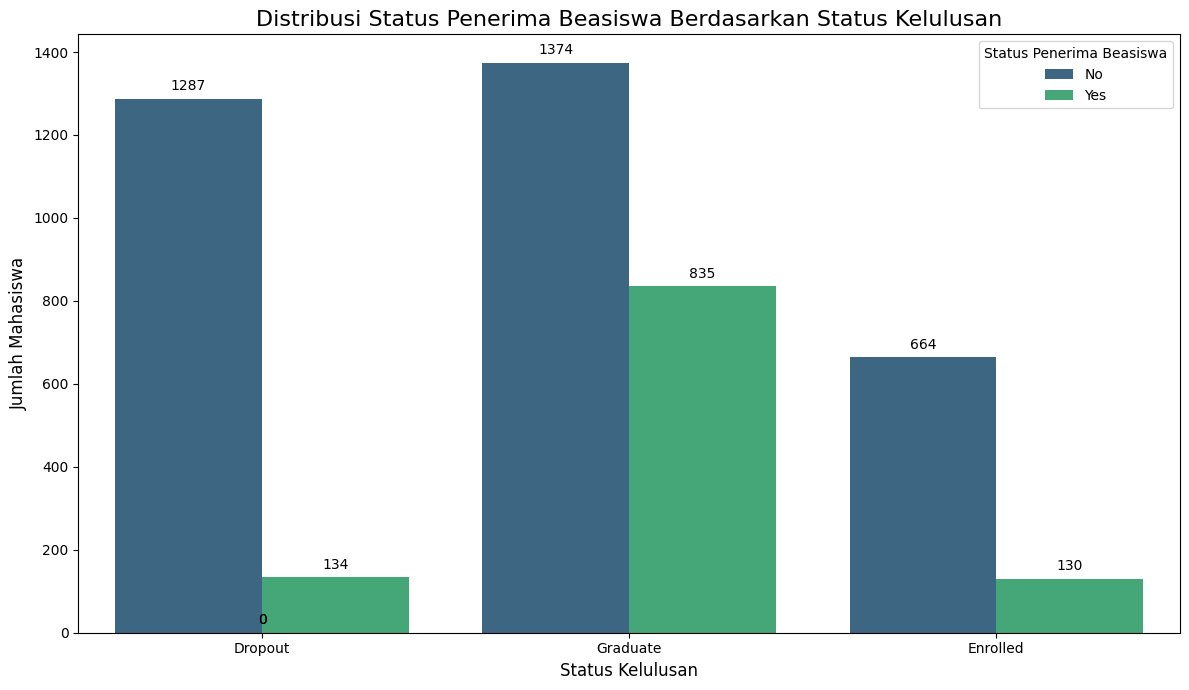

In [88]:
df_eda['Scholarship_holder'] = df['Scholarship_holder'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='Scholarship_holder',
    palette='viridis'
)

plt.title('Distribusi Status Penerima Beasiswa Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Status Penerima Beasiswa')
plt.tight_layout()
plt.show()

Secara ringkas, data ini memberikan bukti yang sangat kuat bahwa program beasiswa adalah intervensi yang paling efektif untuk memerangi angka putus kuliah dan meningkatkan angka kelulusan. Bantuan finansial yang terstruktur tidak hanya sekadar membantu, tetapi secara drastis mengubah nasib akademis seorang mahasiswa dari yang semula berisiko tinggi menjadi sangat berpeluang untuk sukses.

#### **International**

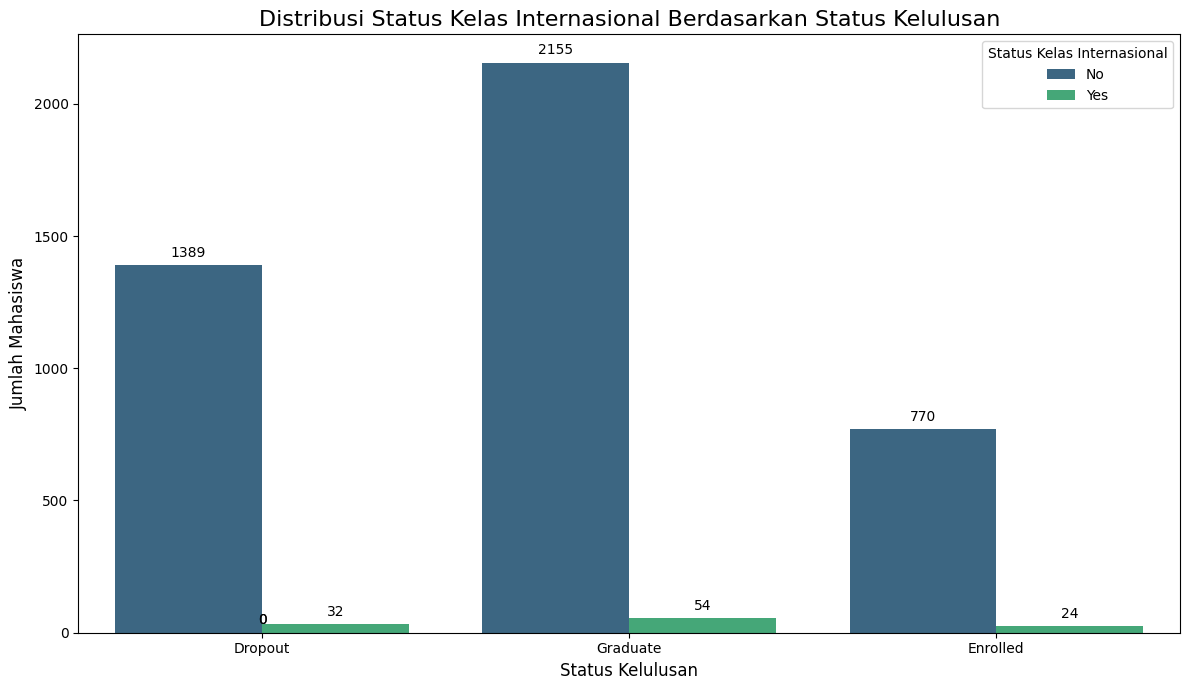

In [89]:
df_eda['International'] = df['International'].map({
    0: 'No',
    1: 'Yes'
})

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_eda,
    x='Status',
    hue='International',
    palette='viridis'
)

plt.title('Distribusi Status Kelas Internasional Berdasarkan Status Kelulusan', fontsize=16)
plt.xlabel('Status Kelulusan', fontsize=12)
plt.ylabel('Jumlah Mahasiswa', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.legend(title='Status Kelas Internasional')
plt.tight_layout()
plt.show()

Secara ringkas, menjadi mahasiswa kelas internasional berkorelasi dengan peluang keberhasilan akademis yang sedikit lebih tinggi. Keunggulan ini kemungkinan besar bukan hanya karena programnya itu sendiri, tetapi juga karena proses seleksi yang lebih ketat yang memilih mahasiswa dengan potensi awal yang lebih tinggi, serta dukungan sumber daya yang lebih baik selama masa studi. Dari segi machine learning datasset ini sangat homogen sekali dan akan dilakukan penghapusan nantinya.

## **Data Preparation / Preprocessing**

### **Drop Fitur Homogen**

Berdasarkan hasil dari tahap Eksplorasi Data (EDA) sebelumnya, ditemukan beberapa fitur yang memiliki nilai yang sangat homogen. Artinya, sebagian besar data terpusat hanya pada satu nilai untuk fitur-fitur tersebut (misalnya, pada fitur 'International', lebih dari 95% mahasiswa adalah bukan mahasiswa internasional). Fitur dengan varians yang sangat rendah seperti ini umumnya tidak memberikan banyak informasi yang berguna bagi model untuk belajar membedakan antar kelas target. Mempertahankannya justru berpotensi menambah kompleksitas model tanpa memberikan kontribusi signifikan terhadap performa prediksi. Oleh karena itu, pada langkah ini kita akan menghapus kolom-kolom tersebut, yaitu Nacionality, Educational_special_needs, dan International.

In [90]:
df = df.drop(['Nacionality', 'Educational_special_needs', 'International'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Mothers_qualification                         4424 non-null   int64  
 8   Fathers_qualification                         4424 non-null   int64  
 9   Mothers_occupation                            4424 non-null   i

### **Pembagian Data**

Sebelum melatih model, langkah persiapan data yang krusial adalah melakukan pembagian data. Proses ini diawali dengan mengubah variabel target 'Status' dari format teks (seperti 'Dropout' atau 'Graduate') menjadi representasi numerik, karena model machine learning memerlukan input berupa angka. Setelah itu, dataset dipisahkan menjadi dua bagian utama: matriks fitur (X) yang berisi semua kolom input, dan vektor target (y) yang berisi kolom 'Status' yang ingin kita prediksi. Langkah terakhir adalah membagi data fitur dan target tersebut menjadi data latih (80%) dan data uji (20%). Data latih akan digunakan untuk "mengajari" model, sementara data uji yang tidak pernah dilihat sebelumnya akan dipakai untuk mengevaluasi performa generalisasi model, di mana penggunaan random_state memastikan proses pembagian ini selalu konsisten.

In [91]:
df['Status'] = df['Status'].map({
    'Dropout' : 0,
    'Graduate' : 1,
    'Enrolled' : 2
})

# Membagi Fitur dan Target
X = df.drop('Status', axis = 1)
y = df['Status']

# Membagi Data Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Oversampling**

Setelah melakukan eksplorasi data, seringkali ditemukan adanya ketidakseimbangan kelas (class imbalance) pada variabel target. Dalam kasus prediksi performa mahasiswa, jumlah mahasiswa yang "Dropout" kemungkinan jauh lebih sedikit dibandingkan yang "Lulus". Jika model dilatih pada data yang tidak seimbang, ia akan cenderung menjadi "bias" dan lebih baik dalam memprediksi kelas mayoritas, sementara performanya pada kelas minoritas (yang seringkali lebih penting untuk diidentifikasi) menjadi buruk.

Untuk mengatasi masalah ini, kita akan menggunakan teknik oversampling pada data latih. Tujuannya adalah untuk menyeimbangkan distribusi kelas dengan cara membuat sampel sintetis (buatan) baru untuk kelas minoritas. Kita akan menggunakan SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Categorical). Varian SMOTE ini dipilih karena secara khusus dirancang untuk menangani dataset yang memiliki campuran fitur numerik dan kategorikal, seperti dataset yang kita miliki.

In [92]:
# Mendefinisikan Index Fitur Kategorical
categorical_features = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16]

# Membuat object SMOTENC
sm = SMOTENC(random_state=42, categorical_features=[18, 19])

# Oversampling
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

# Ukuran
print(f"Ukuran Sebelum SMOTENC : {X_train.shape}")
print(f"Ukuran Sesudah SMOTENC : {X_train_resample.shape}")

Ukuran Sebelum SMOTENC : (3539, 33)
Ukuran Sesudah SMOTENC : (5373, 33)


Dari hasil di atas, dapat dilihat bahwa proses oversampling telah berhasil dijalankan. Jumlah sampel pada data latih (X_train) telah meningkat secara signifikan dari 3539 menjadi 5373, sementara jumlah fitur tetap sama (33).

Peningkatan ini terjadi karena SMOTENC telah menambahkan sampel-sampel sintetis baru ke dalam kelas minoritas (misalnya, kelas "Dropout") hingga jumlahnya menjadi seimbang dengan kelas mayoritas. Dengan dataset yang sekarang lebih seimbang, model yang akan dilatih selanjutnya diharapkan tidak lagi bias dan memiliki kemampuan yang lebih baik untuk mempelajari pola dari kelas minoritas, sehingga dapat meningkatkan metrik evaluasi seperti recall dan F1-score. Langkah berikutnya adalah melatih model menggunakan data yang telah diseimbangkan ini (X_train_resample dan y_train_resample).

## **Modeling**

Setelah data berhasil dibagi menjadi data latih (train) dan data uji (test) serta dilakukan oversampling agar data seimbang, langkah selanjutnya adalah membangun model machine learning. Pada tahap ini, kita akan menggunakan algoritma XGBoost (Extreme Gradient Boosting) untuk membuat model klasifikasi.

XGBoost dipilih karena merupakan salah satu algoritma gradient boosting yang sangat populer dan kuat, dikenal dengan performa tinggi dan kemampuannya untuk menangani berbagai jenis data secara efektif.

In [93]:
# Pembuatan Model XGboost
clf = xgb.XGBClassifier(random_state=42)

# Latih Model pada Data Training
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## **Evaluation**

Setelah model selesai dilatih, tahap selanjutnya adalah evaluasi. Tujuan dari tahap ini adalah untuk mengukur seberapa baik performa model pada data yang belum pernah dilihat sebelumnya, yaitu data uji (test set). Langkah ini sangat penting untuk memvalidasi apakah model dapat melakukan generalisasi dengan baik pada data baru di dunia nyata.

In [94]:
# Gunakan Model untuk Membuat Prediksi pada Data Test
y_pred = clf.predict(X_test)

# Perhitungan Performa
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Akurasi: 0.7627
Presisi: 0.7537
Recall: 0.7627
F1-Score: 0.7542


Berdasarkan hasil evaluasi, model menunjukkan performa yang cukup baik dan seimbang sebagai fondasi awal. Dengan akurasi keseluruhan sebesar 0.7627, model ini secara umum berhasil memprediksi status mahasiswa dengan benar pada sekitar 76% kasus dalam data uji. Skor F1 sebesar 0.7542 mengonfirmasi adanya keseimbangan yang solid antara presisi (0.7537) dan recall (0.7627), yang nilainya saling berdekatan. Hal ini menandakan bahwa model tidak hanya mampu meminimalkan prediksi yang salah (misalnya, salah menandai mahasiswa aman sebagai berisiko), tetapi juga cukup mampu dalam mengidentifikasi sebagian besar mahasiswa yang benar-benar berisiko.

## **Deployment**

Setelah model berhasil dilatih dan dievaluasi dengan hasil yang memuaskan, langkah krusial selanjutnya adalah menyimpan model tersebut. Proses ini sering disebut sebagai persistence atau serialisasi, dan merupakan langkah awal yang fundamental sebelum model dapat di-deploy atau digunakan dalam aplikasi nyata. Tujuannya adalah agar kita tidak perlu mengulang seluruh proses pelatihan setiap kali ingin menggunakan model untuk membuat prediksi.

In [100]:
import joblib
file_name = "xgb_model.model"
joblib.dump(clf, file_name)

['xgb_model.model']